#### Imupurity Photoionization in Liquid Xe ####
Some of the photon generated in proportional scintilation are able to photoionize impurities in liquid xe and create free electrons.
Those electrons then drifted upwards and create signals of their own.

In [292]:
from hax.misc import code_hider
code_hider()

In [62]:
import os, sys, io, time
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if isinstance(sci, str):
        plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))

    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = '$Number\ of\ Entries$')
    else:
        pass

In [2]:
# Read both events and peaks, then merge
class read_n_merge():
    __version__ = '0.0.5'

    def __init__(self):
        self.pre_selection = ['True']
        self.pre_selection = '&'.join(self.pre_selection)
        self._read_flag = True

    def process(self, indir_event='', indir_peak='', outdir='',
                number_file_cap=0, number_cup=1, force_reload=False,):
        # The main function to call (just a personal habbit not to write it as __call__)
        self.indir_event = indir_event; self.indir_peak = indir_peak; self.outdir = outdir
        if not os.path.exists(self.outdir): os.makedirs(self.outdir)
        self.number_file_cap = number_file_cap; self.number_cup = number_cup; self.force_reload = force_reload
        
        # Record all the file in folder, and put a cup on number of files
        event_file_list = [file for file in os.listdir(self.indir_event) if 'pkl' in file]
        peak_file_list = [file for file in os.listdir(self.indir_peak) if 'pkl' in file]
        
        file_list = list(set(event_file_list).intersection(peak_file_list))
        
        if isinstance(self.number_file_cap, int):
            file_list = file_list[:self.number_file_cap]
        else:
            # Back door for hand select files directly
            file_list = self.number_file_cap

        # Process with the choice of using multiple cores
        if self.number_cup > 1:
            # Use multithread processing
            with Pool(processes = self.number_cup) as pool:
                self.result = list(tqdm(pool.imap(self._process, file_list, 1), total = len(file_list)))

        else:
            self.result = []
            # Use a loop to process
            with tqdm(total = len(file_list)) as pBar:
                for file in file_list:
                    pBar.update(1)
                    self.result.append(self._process(file))

        self.result, self.errors = zip(*self.result)

        # Concat and return result
        if len(self.result) != 0: self.result = pd.concat(self.result)
        return self.result

    def _process(self, file):
        # Main function acting on individual files
        self._process_list = [self._check_existance,
                              self._read_pickle,
                              self._reduce_columns,
                              self._merge,
                              self._write,
                             ]
        
        # Initiate result to prevent return none when encounter failure
        temp = pd.DataFrame(); error = None
        rolling_kwarg = dict(file = file)
        
        # Loop over stages of processing
        for proc in self._process_list:
            try:
                rolling_kwarg = (proc(**rolling_kwarg))
            except Exception as error:
                return (temp, (proc.__name__, error))
            if rolling_kwarg['finish_flag']:
                return (rolling_kwarg['temp'], error)
            
    def _check_existance(self, file):
        if os.path.isfile(os.path.join(self.outdir, file)) and (not self.force_reload):
            temp = pd.read_pickle(os.path.join(self.outdir, file))
            return dict(temp = temp, file = file, finish_flag = True)
        else:
            return dict(file = file, finish_flag = False)
            
    def _read_pickle(self, file, finish_flag):
        temp = [pd.read_pickle(os.path.join(self.indir_event, file)),
                pd.read_pickle(os.path.join(self.indir_peak, file))]
        return dict(temp = temp, file = file, finish_flag = False)

    def _reduce_columns(self, temp, file, finish_flag):
        clist = ['event_number','run_number',
                 's1', 's2', 'drift_time', 'x_3d_nn', 'y_3d_nn', 'z_3d_nn',
                 #'s2_area_fraction_top', 's2_range_50p_area', 's2_pattern_fit', 'largest_other_s2',
                ]
        temp[0] = temp[0].loc[:, clist]
        clist = ['area', 'area_fraction_top', 'delay_main_s1', 'delay_main_s2',
                 'event_number', 'global_event_number', #'goodness_of_fit_nn',
                 'goodness_of_fit_tpf', 'hit_time_mean', 'hit_time_mean_global',
                 'range_50p_area', 'range_80p_area', 'range_90p_area', 'rise_time',
                 'type', 'x_nn', 'x_tpf', 'y_nn', 'y_tpf']
        temp[1] = temp[1].loc[:, clist]
        return dict(temp = temp, file = file, finish_flag = False)
    def _merge(self, temp, file, finish_flag):
        temp = temp[0].merge(temp[1], left_on='event_number', right_on='event_number', how='outer')
        return dict(temp = temp, file = file, finish_flag = False)
    
    def _write(self, temp, file, finish_flag):
        temp.to_pickle(os.path.join(self.outdir, file))
        return dict(temp = temp, file = file, finish_flag = True)

In [7]:
print('Loading Data..')
time.sleep(1)
rnm = read_n_merge()
EIDir = '/project2/lgrandi/zhut/data/ce/Sciencerun1_Rn220_LxePI/Elist/'
PIDir = '/project2/lgrandi/zhut/data/ce/Sciencerun1_Rn220_LxePI/S2TrailingPeaks/'
ODir = '/project2/lgrandi/zhut/data/ce/Sciencerun1_Rn220_LxePI/merged'
df = rnm.process(indir_event=EIDir, indir_peak=PIDir, outdir = ODir, number_file_cap = 50, number_cup = 14, force_reload = False)

Loading Data..


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


## Check The Maximum Drift Time ##

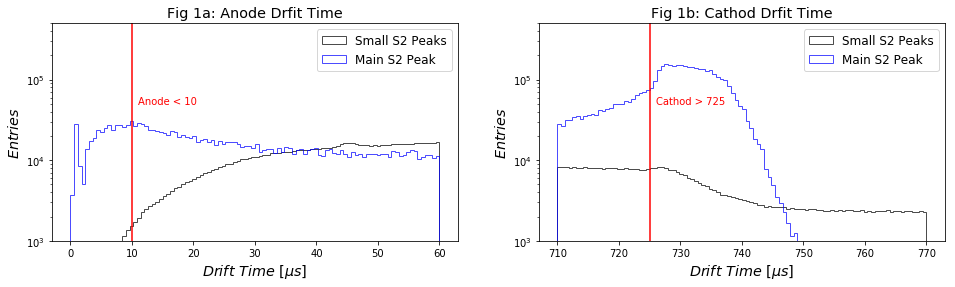

In [19]:
plt.rcParams['figure.figsize'] = (16, 4)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()

args = ['{df}.delay_main_s2/1000', '{df}.drift_time/1000']
ops = [dict(color = 'k', alpha = 0.7, histtype = 'step', bins = 100),
       dict(color = 'b', alpha = 0.7, histtype = 'step', bins = 100),]

ax = fig.add_subplot(121)
dfs = ['df[(df.area > 0)&(df.delay_main_s2 < 1e5)]',
       'df[(df.drift_time < 1e5)]',]
for ix, arg in enumerate(args):
    values = eval(arg.format(df = dfs[ix]))
    plt.hist(values, range = [0, 60], **ops[ix])
plt.legend(['Small S2 Peaks', 'Main S2 Peak'], loc = 'upper right')
plt.axvline(10,color = 'r')
plt.text(11, 5e4, 'Anode < 10', color = 'r')
plt.yscale('log')
plt_config(ybounds = [1e3, 5e5], xlabel = '$Drift\ Time\ [\mu s]$', ylabel = '$Entries$', title = 'Fig 1a: Anode Drfit Time')


ax = fig.add_subplot(122)
dfs = ['df[(df.area > 0)&(df.delay_main_s2 > 7.1e5)]',
       'df[(df.drift_time > 7.1e5)]',]
for ix, arg in enumerate(args):
    values = eval(arg.format(df = dfs[ix]))
    plt.hist(values, range = [710, 770], **ops[ix])
plt.legend(['Small S2 Peaks', 'Main S2 Peak'], loc = 'upper right')
plt.axvline(725,color = 'r')
plt.text(726, 5e4, 'Cathod > 725', color = 'r')
plt.yscale('log')
plt_config(ybounds = [1e3, 5e5], xlabel = '$Drift\ Time\ [\mu s]$', ylabel = '$Entries$', title = 'Fig 1b: Cathod Drfit Time')

plt.show()

## Peak Level Selections ##

  - Peak Area Fraction Top, main distinction of electron peak from after pulses is of cause the area fraction top
  - Peak Pattern likelihood, we can use pattern likelihood to tell a multi-electron peak from a small particle energy deposition. (Instead of peak width which would be dominated by statistical fluctuation)

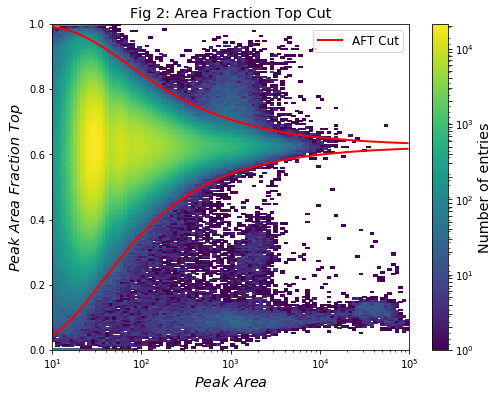

In [20]:
from scipy.stats import beta
plt.rcParams['figure.figsize'] = (8, 6)
fig = plt.figure()

@np.vectorize
def upper_lim(s2):
    return beta.ppf(1-1e-6, a = s2*0.75*0.6256+1, b = s2*0.75*(1-0.6256)+1)
@np.vectorize
def lower_lim(s2):
    return beta.ppf(1e-6, a = s2*0.75*0.6256+1, b = s2*0.75*(1-0.6256)+1)

s2 = np.logspace(0, 10, 10000)
ul = upper_lim(s2); ll = lower_lim(s2)
upper_lim = interp1d(s2, ul, fill_value = 'extrapolate')
lower_lim = interp1d(s2, ll, fill_value = 'extrapolate')

######################################################
ax = fig.add_subplot(111)
args = ['{df}.area', '{df}.area_fraction_top']
df_ = df[(df.area>0) & (df.drift_time > 1e5) & (df.drift_time < 7.25e5)]
dfs = ['df_']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(1, 5, 101), np.linspace(0, 1, 201)]
            )
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))
x = mha.bin_centers(axis = 0)

plt.plot(x, upper_lim(x), 'r-', lw = 2.0)
plt.legend(['AFT Cut'])
plt.plot(x, lower_lim(x), 'r-', lw = 2.0)
plt.xscale('log')
plt_config(xlabel = '$Peak\ Area$', ylabel = '$Peak\ Area\ Fraction\ Top$', title = 'Fig 2: Area Fraction Top Cut')

#df_ = df_[(df_.area_fraction_top < upper_lim(df_.area)) & (df_.area_fraction_top > lower_lim(df_.area))]


plt.show()

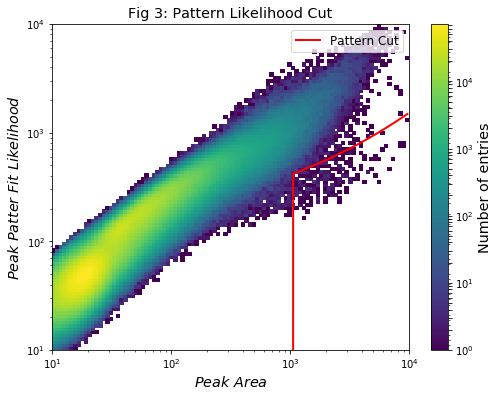

In [21]:
plt.rcParams['figure.figsize'] = (8, 6)
fig = plt.figure()

ax = fig.add_subplot(111)
args = ['{df}.area*{df}.area_fraction_top', '{df}.goodness_of_fit_tpf']
df_ = df[(df.area>0) & (df.drift_time > 1e5) & (df.drift_time < 7.25e5)]
df_ = df_[(df_.area_fraction_top < upper_lim(df_.area)) & (df_.area_fraction_top > lower_lim(df_.area))]
dfs = ['df_']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(1, 4, 101), np.logspace(1, 4, 101)]
            )
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))
x = mha.bin_centers(axis = 0)
x_ = x.copy()
x_[x_<1000] = 3.862
plt.plot(x, 0.1064*x_+758.80*x_**0.05639-819.29,'r-', lw = 2.0)
plt.legend(['Pattern Cut'])
plt.xscale('log'); plt.yscale('log')

plt_config(xlabel = '$Peak\ Area$', ylabel = '$Peak\ Patter\ Fit\ Likelihood$', title = 'Fig 3: Pattern Likelihood Cut')

plt.show()

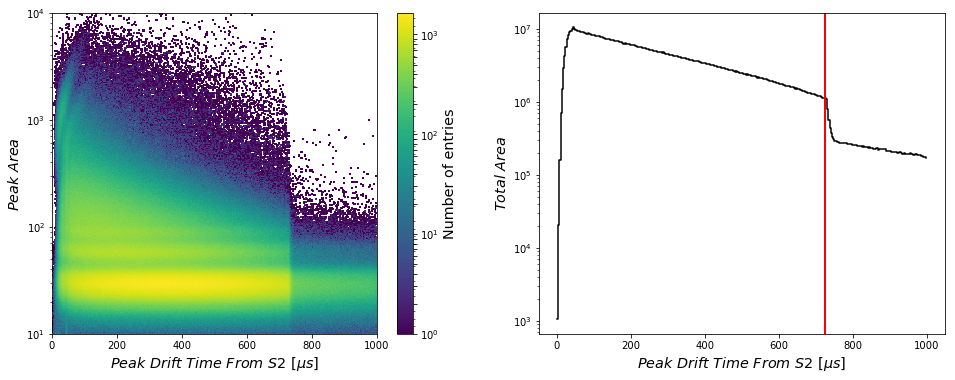

In [23]:
plt.rcParams['figure.figsize'] = (16, 13)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()

def gof_lower(area, aft):
    return 0.1064*area*aft+758.80*(area*aft)**0.05639-819.29

df_ = df[(df.area>0) & (df.drift_time > 1e5) & (df.drift_time < 7.25e5)]
df_ = df_[(df_.area_fraction_top < upper_lim(df_.area)) & (df_.area_fraction_top > lower_lim(df_.area))]
df_ = df_[(df_.goodness_of_fit_tpf > gof_lower(df_.area, df_.area_fraction_top)) | (df_.area < 1000)]
dfs = ['df_']

args = ['{df}.delay_main_s2/1000', '{df}.area']
ax = fig.add_subplot(221)
mh = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
            bins = [np.linspace(0, 1000, 301), np.logspace(1, 4, 301)]
           )
mh.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))
plt.yscale('log')
plt_config(xlabel = '$Peak\ Drift\ Time\ From\ S2\ [\mu s]$', ylabel = '$Peak\ Area$')

ax = fig.add_subplot(222)
average = mh.average(axis = 1)
counts = mh.sum(axis = 1)
summ = Hist1d.from_histogram(average.histogram*counts.histogram, bin_edges = average.bin_edges)
summ.plot(color = 'k')
plt.axvline(725, color = 'r', lw = 2.0)
plt.yscale('log')
plt_config(xlabel = '$Peak\ Drift\ Time\ From\ S2\ [\mu s]$', ylabel = '$Total\ Area$')

plt.show()

## A Few Steps to Get the Normalization ##

  - Getting the average total peak area after main S2 till 735 us later over the main S2 area

In [27]:
df_ = df[(df.area>0) & (df.drift_time > 1e5) & (df.drift_time < 7.25e5)]
df_ = df_[(df_.area_fraction_top < upper_lim(df_.area)) & (df_.area_fraction_top > lower_lim(df_.area))]
df_ = df_[(df_.goodness_of_fit_tpf > gof_lower(df_.area, df_.area_fraction_top)) | (df_.area < 1000)]
df_ = df_[df_.delay_main_s2 < 7.35e5]
df_ = df_.loc[:, ['s2','area','global_event_number']]
len(df_.global_event_number.unique())

df_ = df_.groupby(by = 'global_event_number')

In [28]:
gid, s2, lxe, count = [], [], [], []

def calculations(group):
    pBar.update(1)
    gid.append(group.global_event_number.values[0])
    s2.append(group.s2.values[0])
    lxe.append(np.sum(group.area.values))
    count.append(len(group.index))
    
    group_copy = pd.DataFrame(np.zeros(count[-1]))
    return group_copy

with tqdm(total = len(df_.global_event_number.unique())) as pBar:
    df_ = df_.apply(calculations)


249898it [01:41, 2451.16it/s]                            


Median Ratio: 0.04179


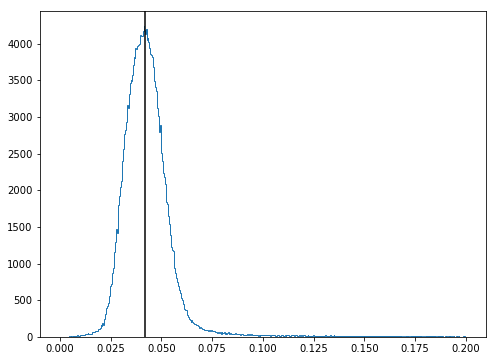

In [33]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
fig = plt.figure()

rate = np.array(lxe)/np.array(s2)
plt.hist(rate, bins = 500, range = [0, 0.2], histtype = 'step')
me = np.median(rate)
plt.axvline(me,color = 'k')
print('Median Ratio: %.5f' %me)

plt.show()

  - Interpolate the probability curve and normalize it
  
Here we are using [single electron gain](https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:analysis:sciencerun1:single_e_gain) and [electron lifetime](https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:analysis:sciencerun1:elifetime)

Best Result For Normalization Factor 1.37431e-11, Residual 0.00000e+00


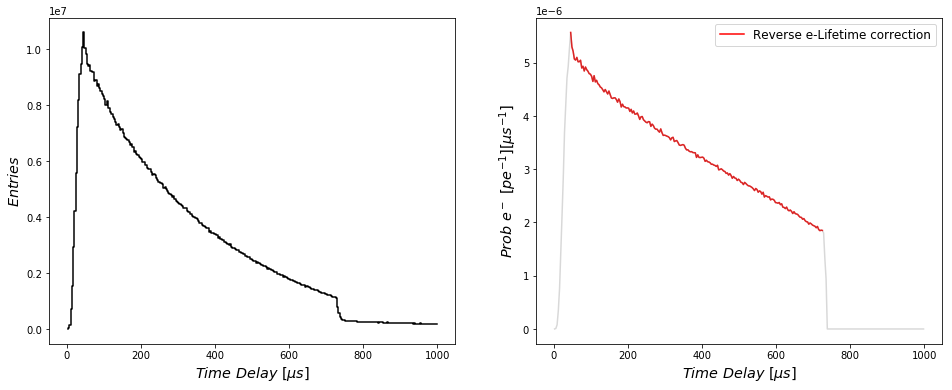

In [301]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

ax = fig.add_subplot(121)
summ.plot(color = 'k')
plt_config(xlabel = '$Time\ Delay\ [\mu s]$', ylabel = '$Entries$')



ax = fig.add_subplot(122)
x = summ.bin_centers
p = interp1d(summ.bin_centers[:221], summ.histogram[:221], bounds_error = False, fill_value = (0,0), kind = 'cubic')
tt = np.linspace(0, 1000, 1000001)
pp = p(tt)

def minimize_func(factor):
    return np.sum(pp)*0.001*factor - me
guesses = [1e-13, 1e-9]

lp, flag = 0, True
while flag:
    temp = 0.5*(guesses[0] + guesses[1])
    y = minimize_func(temp)
    if abs(y) < 1e-17:
        flag = False
    if y > 0:
        guesses[1] = temp
    else:
        guesses[0] = temp
    
    lp += 1
    if lp > 100:
        flag = False
        print('Too many loops')
        
print('Best Result For Normalization Factor %.5e, Residual %.5e'%(temp, y))
nf = temp
for el in [600]:
    _x = np.array(x)[13:218]
    _y = np.array(p(x)*nf/28.21*exp(x/el))[13:218]
    plt.plot(_x, _y, 'r-')
    plt.plot(x, p(x)*nf/28.21*exp(x/el), 'grey', alpha = 0.3)
plt_config(xlabel = '$Time\ Delay\ [\mu s]$', ylabel = '$Prob\ e^-\ [pe^{-1}][\mu s^{-1}]$', sci = 'y')

plt.legend(['Reverse e-Lifetime correction'])

plt.show()

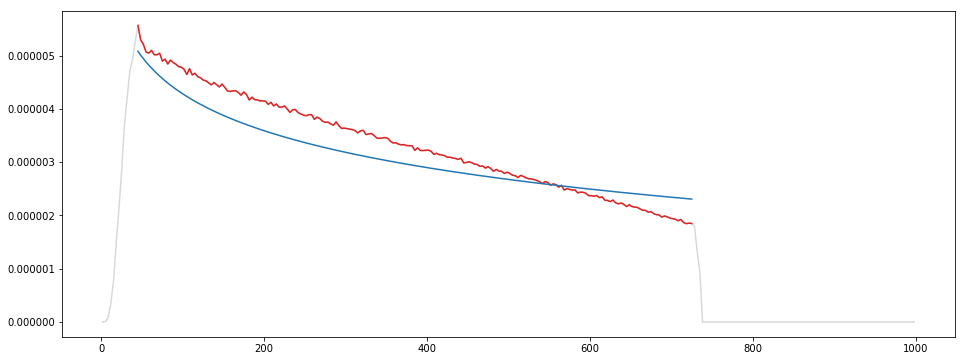

In [324]:
_x = np.array(x)[13:218]
_y = np.array(p(x)*nf/28.21*exp(x/el))[13:218]
plt.plot(_x, _y, 'r-')
plt.plot(x, p(x)*nf/28.21*exp(x/el), 'grey', alpha = 0.3)

@np.vectorize
def gam(x):
    return 0.5e-6*np.log((x**2+(725*10)**2)/(x**2))

@np.vectorize
def gam(x):
    return 0.5e-6*np.log((x**2+(725*10)**2)/(x**2))

plt.plot(_x, gam(_x))
plt_config()

plt.show()

In [46]:
df_out = pd.DataFrame()
df_out['time_from_main_s2'] = np.linspace(0, 1000, 1001)
df_out['probability'] = p(np.linspace(0, 1000, 1001)) * nf
df_out['cumulate'] = np.cumsum(p(np.linspace(0, 1000, 1001)) * nf)
df_out.to_pickle('/home/zhut/data/liquid_impurity_pi.pkl')

$$dN = -\frac{1}{\beta}N\cdot 4\pi r^2 dr$$


$$\longrightarrow \rho=\frac{N_0}{\beta}e^{-\frac{4\pi r^3}{3\beta}}$$


$$N_x =\pi\Delta x\int^{x^2+R_0^2}_{x^2}\rho \cdot d(R^2)$$


$$\longrightarrow N_x=\frac{\Delta xN_0\pi}{\beta}(-\frac{2}{3})(\frac{1}{\beta^\prime})^{-2/3}\Gamma(\frac{2}{3},\frac{\eta^{3/2}}{\beta^\prime})\bracevert^{x^2+R_0^2}_{x^2}$$

or if we assume $$\rho=\frac{N_0}{\beta r^2}$$

$$\longrightarrow N_x=\frac{\Delta xN_0\pi}{\beta}\cdot log\frac{x^2+R_0^2}{x^2}$$

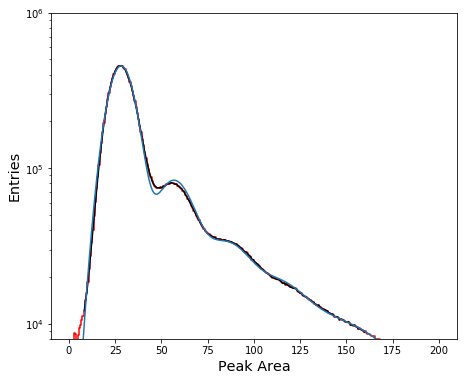

In [296]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

from scipy.stats import norm, poisson

def multi_gauss(area, a1, a2, a3, a4, a5, a6, b, c):
    ans = 0
    for ix, a in enumerate([a1, a2, a3, a4, a5, a6]):
        ans += a * norm.pdf(area, loc = b*(ix+1), scale = np.sqrt(ix+1)*c)
    return ans

ax = fig.add_subplot(121)
ph = Hist1d(df.area, range = [0, 2e2], bins = 300)
ph.plot(color = 'r')
plt.yscale('log')

_x = np.array(ph.bin_centers[12:240])
_y = np.array(ph.histogram[12:240])
plt.plot(_x, _y, color = 'k')

r = curve_fit(multi_gauss, _x, _y, p0 = [1e7, 1e6, 1e6, 1e5, 1e5, 1e4, 28, 8])[0]
x = ph.bin_centers
plt.plot(x, multi_gauss(x, *r))

plt_config(ybounds = [8e3, 1e6], xlabel = 'Peak Area', ylabel = 'Entries')
plt.show()